In [1]:
from copy import deepcopy
import csv
import sys
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.ticker as mtick
matplotlib.rc('font', family='DejaVu Sans', stretch="condensed")

In [2]:
DATA_TYPE_MAP = {
    "advertising identifier": "advertising id",
    "android id": "android id",
    "router ssid": "router ssid",
    "gsfid": "gsf id",
    "application instal": "package dump",

    "imei": "imei",
    "serial number": "serial number",
    "sim serial number": "sim serial number",
    "mac address": "mac address",

    "geographical location": "geolocation",

    "email address": "email address",
    "phone number": "phone number",
    "person name": "person name",
}
PURPOSE_MAPPING = {
    'services': 'core',
    'security': 'core',
    'legal': 'core',

    'analytics': 'non-core',
    'advertising': 'non-core',
}

def check_app_data_consistency(consistency_set):
    if "omitted" in consistency_set:
        if len(consistency_set) == 1:
            return "omitted"
        else:
            return "partial"
    elif "vague" in consistency_set:
        return "vague"
    else:
        assert len(consistency_set) == 1 and "clear" in consistency_set
        return "clear"

our_csv = "../policheck-flow-result.csv"
policheck_csv = "/data/cuih7/policheck/PrivacyPolicyAnalysis/policheck_results.csv"

our_app_data_graph = nx.DiGraph()
our_app_ids = set()
our_collection_consistency = dict()
policheck_app_data_graph = nx.DiGraph()
policheck_app_ids = set()


with open(our_csv, newline="") as fin:
    for row in csv.DictReader(fin):
        app_id = row["app_id"]
        consistency = row["policheck_consistency"]
        collection_consistency = row["collection_consistency"]
        data_type = row["data_type"]
        purposes = {PURPOSE_MAPPING[i] for i in row["purposes"].split("|") if i in PURPOSE_MAPPING}
        our_app_ids.add(app_id)

        if not our_app_data_graph.has_edge(app_id, data_type):
            our_app_data_graph.add_edge(app_id, data_type, consistency=set(), purposes=set())

        our_app_data_graph[app_id][data_type]["consistency"].add(consistency)
        our_app_data_graph[app_id][data_type]["purposes"].update(purposes)
        our_collection_consistency[(app_id, data_type)] = collection_consistency


with open(policheck_csv, newline="") as fin:
    for row in csv.DictReader(fin):
        app_id = row["packageName"]
        data_type = DATA_TYPE_MAP[row["flowData"]]
        policheck_app_ids.add(app_id)

        if row["consistencyResult"] == "clear":
            consistency = "clear"
        elif row["consistencyResult"] in "vague":
            consistency = "vague"
        else:
            consistency = "omitted"

        if not policheck_app_data_graph.has_edge(app_id, data_type):
            policheck_app_data_graph.add_edge(app_id, data_type, consistency=set())

        policheck_app_data_graph[app_id][data_type]["consistency"].add(consistency)

our_result_dict = {
    "clear": {i: 0 for i in DATA_TYPE_MAP.values()},
    "vague": {i: 0 for i in DATA_TYPE_MAP.values()},
    "partial": {i: 0 for i in DATA_TYPE_MAP.values()},
    "omitted": {i: 0 for i in DATA_TYPE_MAP.values()},
}
our_result_no_entity_dict = deepcopy(our_result_dict)
policheck_result_dict = deepcopy(our_result_dict)
purpose_dict = {
    "core": {i: 0 for i in DATA_TYPE_MAP.values()},
    "mix": {i: 0 for i in DATA_TYPE_MAP.values()},
    "non-core": {i: 0 for i in DATA_TYPE_MAP.values()},
    "unknown": {i: 0 for i in DATA_TYPE_MAP.values()},
}

# Only report common app_ids
for app_id in policheck_app_ids & our_app_ids:
    dt_set1 = {dt for _, dt in our_app_data_graph.edges(app_id)}
    dt_set2 = {dt for _, dt in policheck_app_data_graph.edges(app_id)}

    # Only report common data types
    for data_type in dt_set1 & dt_set2:
        c1 = check_app_data_consistency(our_app_data_graph[app_id][data_type]["consistency"])
        our_result_dict[c1][data_type] += 1
        c2 = check_app_data_consistency(policheck_app_data_graph[app_id][data_type]["consistency"])
        policheck_result_dict[c2][data_type] += 1

        our_result_no_entity_dict[our_collection_consistency[(app_id, data_type)]][data_type] += 1

        purpose_list = our_app_data_graph[app_id][data_type]["purposes"]
        if len(purpose_list) == 2:
            purpose_dict["mix"][data_type] += 1
        elif "non-core" in purpose_list:
            purpose_dict["non-core"][data_type] += 1
        elif "core" in purpose_list:
            purpose_dict["core"][data_type] += 1
        else:
            purpose_dict["unknown"][data_type] += 1

our_result = pd.DataFrame(our_result_dict)
our_result_no_entity = pd.DataFrame(our_result_no_entity_dict)
policheck_result = pd.DataFrame(policheck_result_dict)
purpose_result = pd.DataFrame(purpose_dict)

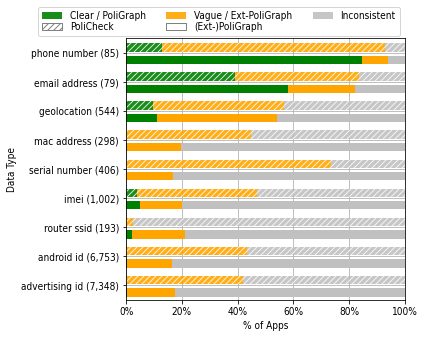

In [5]:
df1 = our_result.drop(["person name", "package dump", "gsf id", "sim serial number"])
df1 = df1.div(df1.sum(axis=1), axis=0)
df1["omitted"] += df1["partial"]
df1.drop("partial", axis=1, inplace=True)

df2 = policheck_result.drop(["person name", "package dump", "gsf id", "sim serial number"])
df2 = df2.div(df2.sum(axis=1), axis=0)
df2["omitted"] += df2["partial"]
df2.drop("partial", axis=1, inplace=True)

#ax = df1.plot.barh(stacked=True, color=["green", "blue", "orange", "gray"], figsize=(6, 3.5))
#fig = ax.get_figure()

fig, ax = plt.subplots(figsize=(6, 4.8))
df2.plot.barh(stacked=True, width=0.3, position=-0.1, ax=ax, alpha=0.9, color=["green", "orange", "silver", "whitesmoke"])
df2.plot.barh(stacked=True, width=0.3, position=-0.1, ax=ax, hatch="////", alpha=0.8, color="none", lw=0.0, edgecolor="white")
df1.plot.barh(stacked=True, width=0.3, position=1.3, ax=ax, color=["green", "orange", "silver", "whitesmoke"])

new_labels = []
for item in ax.get_yticklabels():
    label = item.get_text() + " ({0:,})".format(our_result.loc[item.get_text()].sum())
    new_labels.append(label)
ax.set_yticklabels(new_labels)

# Set legends
handles, labels = [], []
for handle, label in zip(*ax.get_legend_handles_labels()):
    if label == "clear":
        label = "Clear / PoliGraph"
    elif label == "vague":
        label = "Vague / Ext-PoliGraph"
    elif label == "omitted":
        label = "Inconsistent"

    handles.append(handle)
    labels.append(label)
    if len(handles) == 3:
        break

new_handle = matplotlib.patches.Patch(color='white', hatch="")
new_handle.set_edgecolor("grey")
handles.insert(2, new_handle)
labels.insert(2, "(Ext-)PoliGraph")

new_handle = matplotlib.patches.Patch(color='white', hatch="////")
new_handle.set_edgecolor("grey")
handles.insert(1, new_handle)
labels.insert(1, "PoliCheck")

ax.legend(handles, labels, labelspacing=0.1, loc="upper right", bbox_to_anchor=(1, 1.14), ncol=3)



ax.set_ylim(-0.5, 8.5)
ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#ax.legend(["Clear / PoliGraph", "Vague / Ext-PoliGraph", "Partial", "Not Found"], loc="lower right")
ax.set_axisbelow(True)
ax.grid()
ax.set_xlabel("% of Apps")
ax.set_ylabel("Data Type")
fig.set_tight_layout(True)

plt.savefig("figs/network-our.pdf")

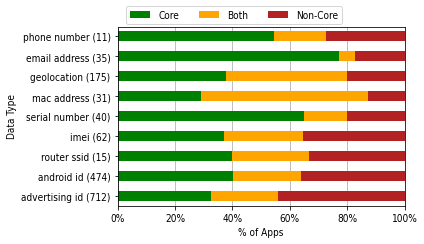

In [6]:
df_new = purpose_result.drop(["person name", "package dump", "gsf id", "sim serial number"])
df_new = df_new.drop("unknown", axis=1)
sample_count = df_new.sum(1)
df_new = df_new.div(df_new.sum(axis=1), axis=0)

ax = df_new.plot.barh(stacked=True, color=["green", "orange", "firebrick", "gray"], figsize=(6, 3.5))
fig = ax.get_figure()

new_labels = []
for item in ax.get_yticklabels():
    label = item.get_text() + " ({0:,})".format(sample_count.loc[item.get_text()].sum())
    new_labels.append(label)
ax.set_yticklabels(new_labels)

ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#ax.legend(handles, labels, labelspacing=0.1, loc="upper right", bbox_to_anchor=(1, 1.14), ncol=3)

ax.legend(["Core", "Both", "Non-Core", "Unknown"], bbox_to_anchor=(0.8, 1.14), ncol=3)
ax.set_axisbelow(True)
ax.grid()
ax.set_xlabel("% of Apps")
ax.set_ylabel("Data Type")
fig.set_tight_layout(True)
plt.savefig("figs/network-purpose.pdf")